# MMA Descriptor with Differentiable Optimization

This notebook demonstrates the `compute_mma_descriptor` function that computes Multiparameter Module Approximation (MMA) descriptors from a scalar field and its derivative. The function constructs a bifiltration using cubical complexes and returns differentiable topological descriptors.

**Important limitation**: Custom grids break gradient computation. The function only maintains differentiability with `grid=None` (automatic grid generation). Custom grids cause the loss of gradient information due to limitations in the multipers library.

In [1]:
import torch
import multipers as mp
from multipers.filtrations import Cubical
from multipers.torch.diff_grids import get_grid, evaluate_mod_in_grid

[KeOps] Warning : omp.h header is not in the path, disabling OpenMP. To fix this, you can set the environment
                  variable OMP_PATH to the location of the header before importing keopscore or pykeops,
                  e.g. using os.environ: import os; os.environ['OMP_PATH'] = '/path/to/omp/header'
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


In [2]:
def create_grid_from_data(filtration_values, strategy="regular_closest", resolution=50):
    """
    Creates a grid based on filtration values, optimized for PyTorch compatibility.
    This function generates a grid for evaluating bifiltration data, supporting different
    strategies (e.g., "regular_closest" or "exact") and resolutions.
    
    WARNING: Custom grids break gradient computation. Use grid=None in compute_mma_descriptor
    for differentiable operations.
    
    Args:
        filtration_values (list[torch.Tensor]): A list of 1D PyTorch tensors,
            each representing filtration values for a parameter.
        strategy (str, optional): The grid generation strategy. Defaults to "regular_closest".
        resolution (int or list[int], optional): The resolution for grid creation.
            If an integer, the same resolution is used for all parameters. Defaults to 50.
    
    Returns:
        tuple: A grid optimized for the input data, compatible with PyTorch operations.
    """
    grid_function = get_grid(strategy)
    if strategy == "exact":
        grid = grid_function(filtration_values)
    else:
        if isinstance(resolution, int):
            resolution = [resolution] * len(filtration_values)
        grid = grid_function(filtration_values, resolution)
    return grid

def compute_mma_descriptor(field, derivative, degree=1, grid=None):
    """
    Computes the MMA (Multiparameter Module Approximation) descriptor for a scalar field
    and its derivative on a 2D grid.
    
    This function processes a scalar field and its derivative, constructs a bifiltration,
    and computes the topological descriptor using cubical filtrations. The output is
    differentiable if inputs are PyTorch tensors with gradients enabled.
    
    Parameters:
        field (torch.Tensor or np.ndarray): A 2D tensor/array of shape (n, m)
            representing the scalar field.
        derivative (torch.Tensor or np.ndarray): A 2D tensor/array of shape (n, m)
            representing the derivative of the field.
        degree (int, optional): The degree of the homology group to evaluate. Defaults to 1.
        grid (tuple, optional): A precomputed grid for evaluation. If None, a grid is
            automatically generated. Defaults to None.
            WARNING: Custom grids break gradient computation. Use grid=None for differentiable operations.
    
    Returns:
        tuple:
            - result (torch.Tensor): The evaluated MMA descriptor for the specified degree.
            - mma (object): The module approximation object for further analysis.
    
    Notes:
        - If NumPy arrays are passed as inputs, they are automatically converted to PyTorch tensors.
        - The function preserves differentiability when PyTorch tensors with gradients are used ONLY with grid=None.
        - Custom grids break the gradient computation due to limitations in the multipers library.
    """
    # Ensure inputs are PyTorch tensors
    if not isinstance(field, torch.Tensor):
        field = torch.from_numpy(field)
    if not isinstance(derivative, torch.Tensor):
        derivative = torch.from_numpy(derivative)
    
    # Construct bifiltration (stack field and derivative along the last dimension)
    bifiltration = torch.stack([field, derivative], dim=-1)
    temp = Cubical(bifiltration)
    mma = mp.module_approximation(temp)
    
    # Generate grid if not provided
    if grid is None:
        filtration_values = [field.flatten(), derivative.flatten()]
        grid = create_grid_from_data(filtration_values, strategy='exact')
    
    result = evaluate_mod_in_grid(mma, grid)
    
    if degree >= len(result):
        print(f"Warning: grado {degree} non disponibile, gradi disponibili: {list(range(len(result)))}")
        return None, mma
    
    # Evaluate the module approximation on the grid
    return result[degree], mma

In [3]:
mp.__version__

'2.3.2'

/var/folders/wm/x82vy0nj1m10365nrn143qrc0000gn/T/ipykernel_24918/2103324317.py:67: UserWarning: (copy warning) Got a squeezed input. 
  mma = mp.module_approximation(temp)
/var/folders/wm/x82vy0nj1m10365nrn143qrc0000gn/T/ipykernel_24918/2103324317.py:67: UserWarning: (copy warning) Got a non-vine slicer as an input. Use `vineyard=True` to remove this copy.
  mma = mp.module_approximation(temp)
/Users/karthikviswanathan/opt/anaconda3/envs/multipersEnv/lib/python3.12/site-packages/multipers/plots.py:279: UserWarning: Shapely not installed. Fallbacking to matplotlib. The plots may be inacurate.
  warn(


(tensor([[0.0596, 0.3170],
        [0.0622, 0.2421],
        [0.0923, 0.0820],
        [0.4337, 0.0308]], grad_fn=<SplitWithSizesBackward0>), tensor([[0.4440, 0.9964],
        [0.7985, 0.9306],
        [0.8628, 0.8172],
        [0.9888, 0.6185]], grad_fn=<SplitWithSizesBackward0>))


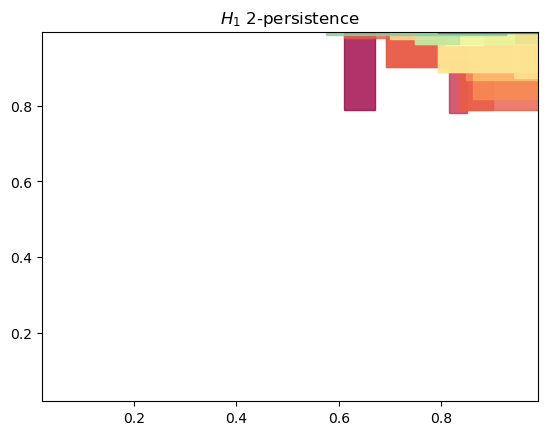

In [4]:
# Example usage
field = torch.rand(10, 10, requires_grad=True)
derivative = torch.rand(10, 10, requires_grad=True)
result, mma = compute_mma_descriptor(field, derivative)
mma.plot(1)
print(result)

## Minimal Optimization Example

We create a synthetic Gaussian field with two peaks and its analytical derivative along the x-direction. The field represents a spatial density distribution, while the derivative captures its spatial gradient. 

Using Adam optimizer, we minimize the sum of all birth and death coordinates in the MMA descriptor (degree 0). This loss function encourages topological simplification by reducing the complexity of connected components in the bifiltration.

/var/folders/wm/x82vy0nj1m10365nrn143qrc0000gn/T/ipykernel_24918/2103324317.py:67: UserWarning: (copy warning) Got a squeezed input. 
  mma = mp.module_approximation(temp)
/var/folders/wm/x82vy0nj1m10365nrn143qrc0000gn/T/ipykernel_24918/2103324317.py:67: UserWarning: (copy warning) Got a non-vine slicer as an input. Use `vineyard=True` to remove this copy.
  mma = mp.module_approximation(temp)


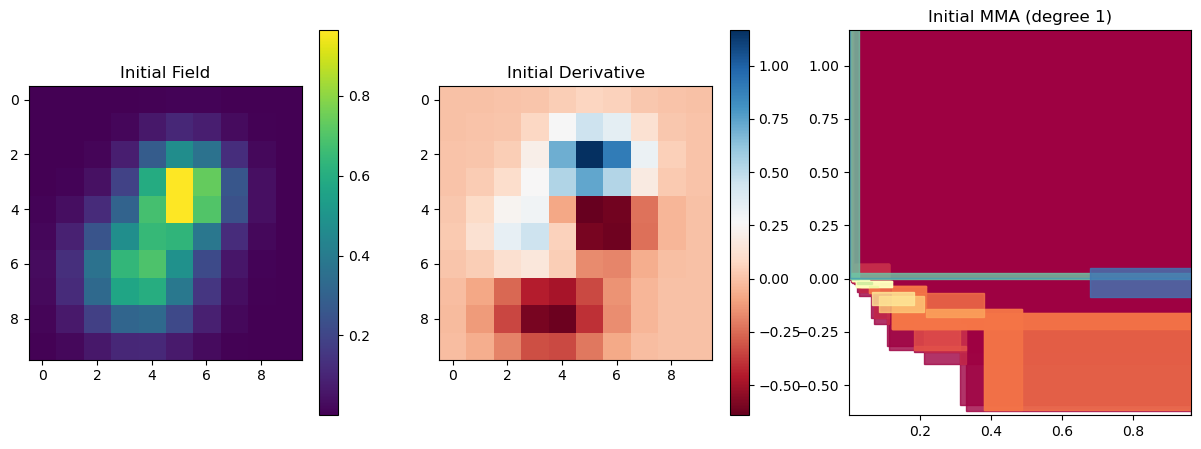

/var/folders/wm/x82vy0nj1m10365nrn143qrc0000gn/T/ipykernel_24918/2103324317.py:67: UserWarning: (copy warning) Got a squeezed input. 
  mma = mp.module_approximation(temp)
/var/folders/wm/x82vy0nj1m10365nrn143qrc0000gn/T/ipykernel_24918/2103324317.py:67: UserWarning: (copy warning) Got a non-vine slicer as an input. Use `vineyard=True` to remove this copy.
  mma = mp.module_approximation(temp)


Epoch 0, Loss: 0.681
Epoch 3, Loss: -3.795
Epoch 6, Loss: -8.223
Epoch 9, Loss: -12.538


/Users/karthikviswanathan/opt/anaconda3/envs/multipersEnv/lib/python3.12/site-packages/multipers/plots.py:279: UserWarning: Shapely not installed. Fallbacking to matplotlib. The plots may be inacurate.
  warn(


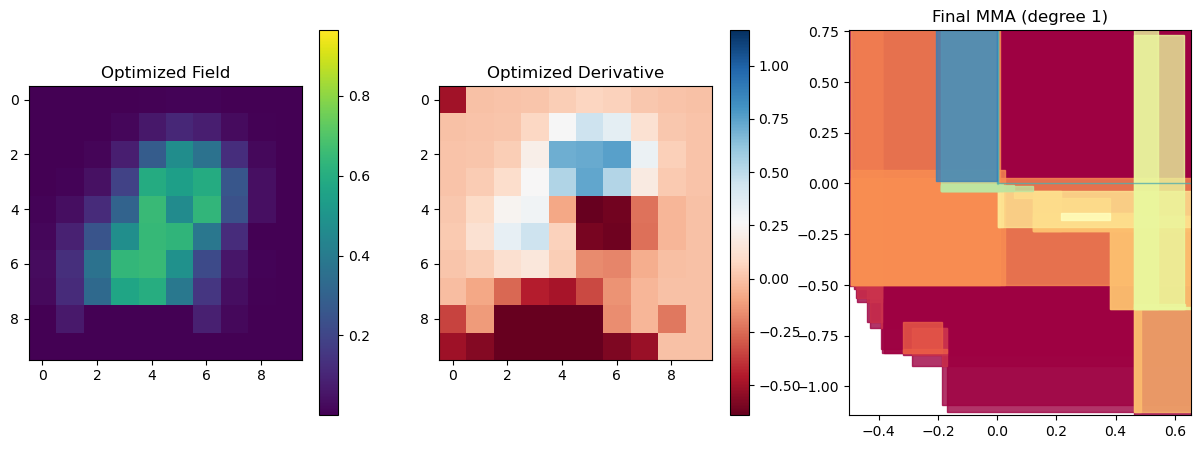

In [5]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# Create spatial grid from -2 to 2 with 10x10 resolution
x = torch.linspace(-2, 2, 10)
y = torch.linspace(-2, 2, 10)
X, Y = torch.meshgrid(x, y, indexing='ij')

# Create Gaussian field with two peaks at different locations and intensities
# Peak 1: centered at (-0.5, 0.3) with full intensity
# Peak 2: centered at (0.8, -0.4) with 0.7 intensity
field = (torch.exp(-((X + 0.5)**2 + (Y - 0.3)**2) / 0.5) +
         0.7 * torch.exp(-((X - 0.8)**2 + (Y + 0.4)**2) / 0.8))

# Compute analytical derivative of the field along x-direction
# This represents the spatial gradient of the density field
derivative = (-(X + 0.5) / 0.25 * torch.exp(-((X + 0.5)**2 + (Y - 0.3)**2) / 0.5) +
              -0.7 * (X - 0.8) / 0.4 * torch.exp(-((X - 0.8)**2 + (Y + 0.4)**2) / 0.8))

# Enable gradient computation for optimization
field.requires_grad_(True)
derivative.requires_grad_(True)

# Visualize initial state: field, derivative, and topological signature
_, mma_initial = compute_mma_descriptor(field, derivative, degree=1)
plt.figure(figsize=(15, 5))

# Get min/max values for consistent colorbars
field_min, field_max = field.min().item(), field.max().item()
deriv_min, deriv_max = derivative.min().item(), derivative.max().item()

plt.subplot(1, 3, 1)
plt.imshow(field.detach(), cmap='viridis', vmin=field_min, vmax=field_max)
plt.title('Initial Field')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(derivative.detach(), cmap='RdBu', vmin=deriv_min, vmax=deriv_max)
plt.title('Initial Derivative')
plt.colorbar()

plt.subplot(1, 3, 3)
mma_initial.plot(0)
plt.title('Initial MMA (degree 1)')
plt.show()

# Optimization loop: minimize topological complexity measured by MMA descriptor
optimizer = optim.Adam([field, derivative], lr=0.05)

for epoch in range(10):
    optimizer.zero_grad()
    
    # Compute MMA descriptor for current field/derivative configuration
    result, _ = compute_mma_descriptor(field, derivative, degree=0)
    
    # Create loss function: sum of all birth and death coordinates
    # This encourages simpler topological structure
    loss_components = []
    for item in result:
        if isinstance(item, tuple):
            birth, death = item
            loss_components.append(birth.sum() + death.sum())
        else:
            loss_components.append(item.sum())
    loss = sum(loss_components)
    
    # Backpropagate and update parameters
    loss.backward()
    optimizer.step()
    
    if epoch % 3 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.3f}")

# Visualize final optimized state
_, mma_final = compute_mma_descriptor(field, derivative, degree=1)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(field.detach(), cmap='viridis', vmin=field_min, vmax=field_max)
plt.title('Optimized Field')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(derivative.detach(), cmap='RdBu', vmin=deriv_min, vmax=deriv_max)
plt.title('Optimized Derivative')
plt.colorbar()

plt.subplot(1, 3, 3)
mma_final.plot(0)
plt.title('Final MMA (degree 1)')
plt.show()

## Results Analysis

The optimization successfully minimizes topological complexity. As shown in the plots:

- **Field flattening**: The Gaussian peaks become less pronounced, reducing spatial variation
- **Loss reduction**: The decreasing loss confirms that topological information is being minimized